<a href="https://colab.research.google.com/github/sarathsreedharan/CSU_CS_445/blob/main/Spring25/Notebooks/module08-02-transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers

*Adapted from various sources, e.g., https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html and https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/*

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

## Transformers 101

## Self-Attention

Previously we talked about different types of attention mechanisms.  Attention mechanisms are just neural networks, usually standard feed-forward neural networks, that compute alignment scores between different parts of the input based on metrics of how they match.

The simplest one is *dot product attention*, which is just $s_th_i$, the dot product of the hidden state $s$ associated with some element $y_t$ of the output, and the hidden state $h$ associated with some element of the input $x_i$.

Since dot product attention (and scaled dot product attention) don't depend on a trained weight matrix to adjust the values, we can easily plot what the effect of this will be on toy samples.

In [4]:
def softmax(vector):
    e = np.exp(vector)
    return e / e.sum()

(array([[0.19203896, 0.07064719, 0.07064719],
        [0.07064719, 0.19203896, 0.07064719],
        [0.07064719, 0.07064719, 0.19203896]]),
 <matplotlib.image.AxesImage at 0x7d4e93293fd0>)

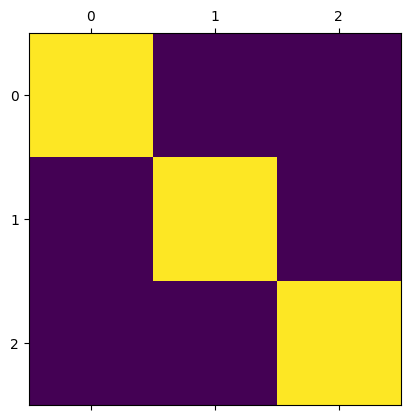

In [5]:
s = np.array([[1,0,0],[0,1,0],[0,0,1]])
h = np.array([[1,0,0],[0,1,0],[0,0,1]])
softmax(s@h),plt.matshow(softmax(s@h))

Consider two languages, English, which has S-V-O word order ("man bites dog"), and Irish, which has V-S-O (bites-man-dog) word order.  A trained attention matrix between two equivalent 3-word sentences might look like:

(array([[0.07064719, 0.19203896, 0.07064719],
        [0.19203896, 0.07064719, 0.07064719],
        [0.07064719, 0.07064719, 0.19203896]]),
 <matplotlib.image.AxesImage at 0x7d4e68f64410>)

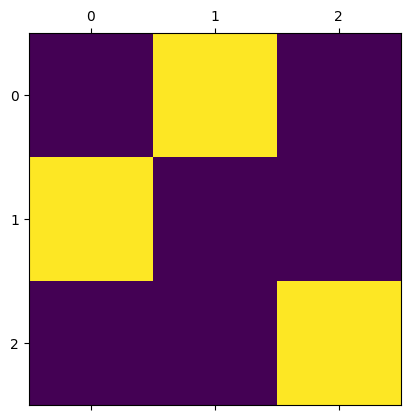

In [7]:
s = np.array([[1,0,0],[0,1,0],[0,0,1]])
h = np.array([[0,1,0],[1,0,0],[0,0,1]])
softmax(s@h),plt.matshow(softmax(s@h))

With some randomness added to the weights:

(array([[0.07643087, 0.18161548, 0.08981243],
        [0.13736404, 0.11569462, 0.09288636],
        [0.08800219, 0.0763772 , 0.14181683]]),
 <matplotlib.image.AxesImage at 0x38bccb8e0>)

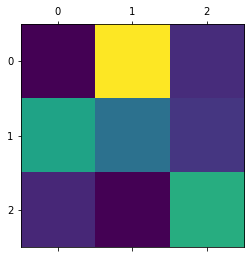

In [ ]:
s = np.array([[1,0,0],[0,1,0],[0,0,1]])+np.random.uniform(-.5, .5, size=(3, 3))
h = np.array([[0,1,0],[1,0,0],[0,0,1]])+np.random.uniform(-.5, .5, size=(3, 3))
softmax(s@h),plt.matshow(softmax(s@h),vmax=np.max(softmax(s@h)))

Using scaled dot product attention instead:

(array([[0.04412738, 0.10485575, 0.05185323],
        [0.07930716, 0.06679632, 0.05362796],
        [0.05080809, 0.04409639, 0.08187798]]),
 <matplotlib.image.AxesImage at 0x38b4722e0>)

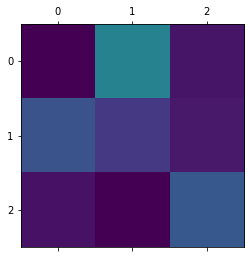

In [ ]:
softmax(s@h)/np.sqrt(3),plt.matshow(softmax(s@h)/np.sqrt(3),vmax=np.max(softmax(s@h)))

As mentioned, attention mechanisms are a whole category of algorithms.  One subcategory is **self-attention**.

Given that attention operates over sequences, we can train attention mechanisms to align elements *within* the input sequence by simply setting the input and output sequence to the same thing!

a.k.a. **intra-attention**, self-attention relates different positions of a single sequence in order to compute a representation of the same sequence. It has been shown to be very useful in machine reading, abstractive summarization, or image description generation.

[This paper](https://arxiv.org/pdf/1601.06733.pdf) uses self-attention in an LSTM for machine reading.

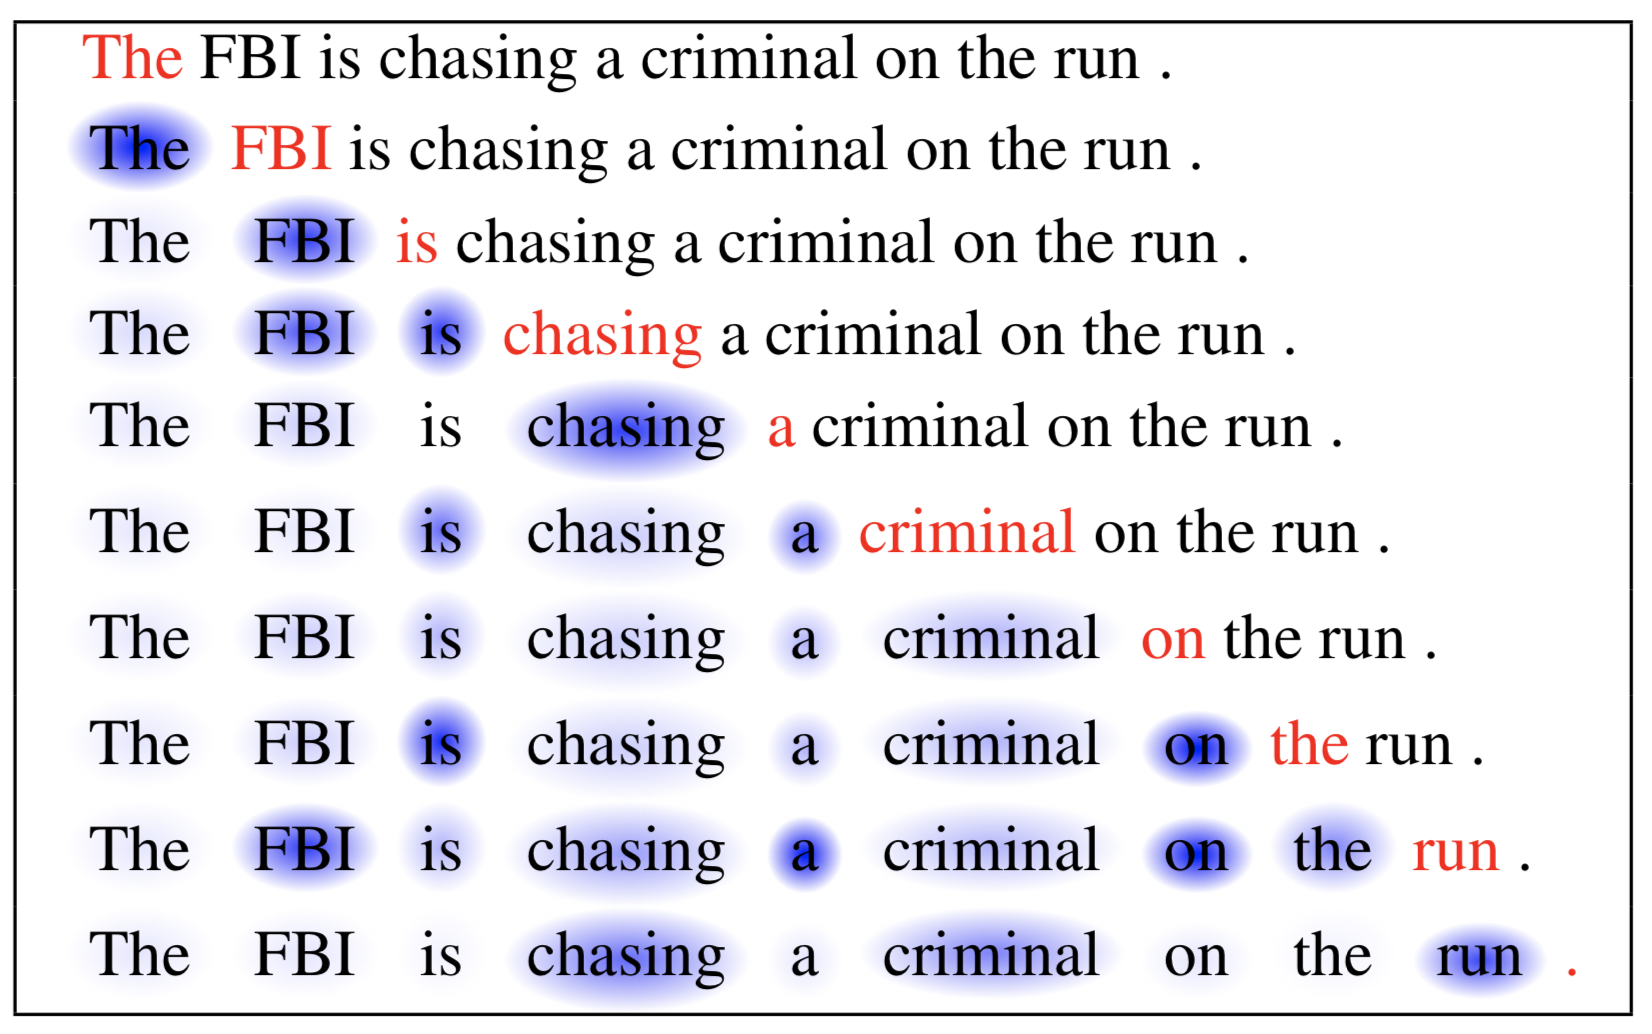

The current word is in red and the size of the blue shade indicates the activation level. (Image source: Cheng et al., 2016)

## Soft vs. Hard Attention

Turning again to vision problems, attention can also be applied here.

In [this paper](http://proceedings.mlr.press/v37/xuc15.pdf), they apply an attention mechanism to images to generate captions.  Alignments can be computed between image patches and words.  When a trained CNN is passed over the images, filters and patches multiply to create feature maps.  Then a LSTM decoder consumes the feature maps to produce descriptive words one by one, where the weights are learned through attention. The visualization of the attention weights clearly demonstrates which regions of the image the model is paying attention to so as it generates certain words.

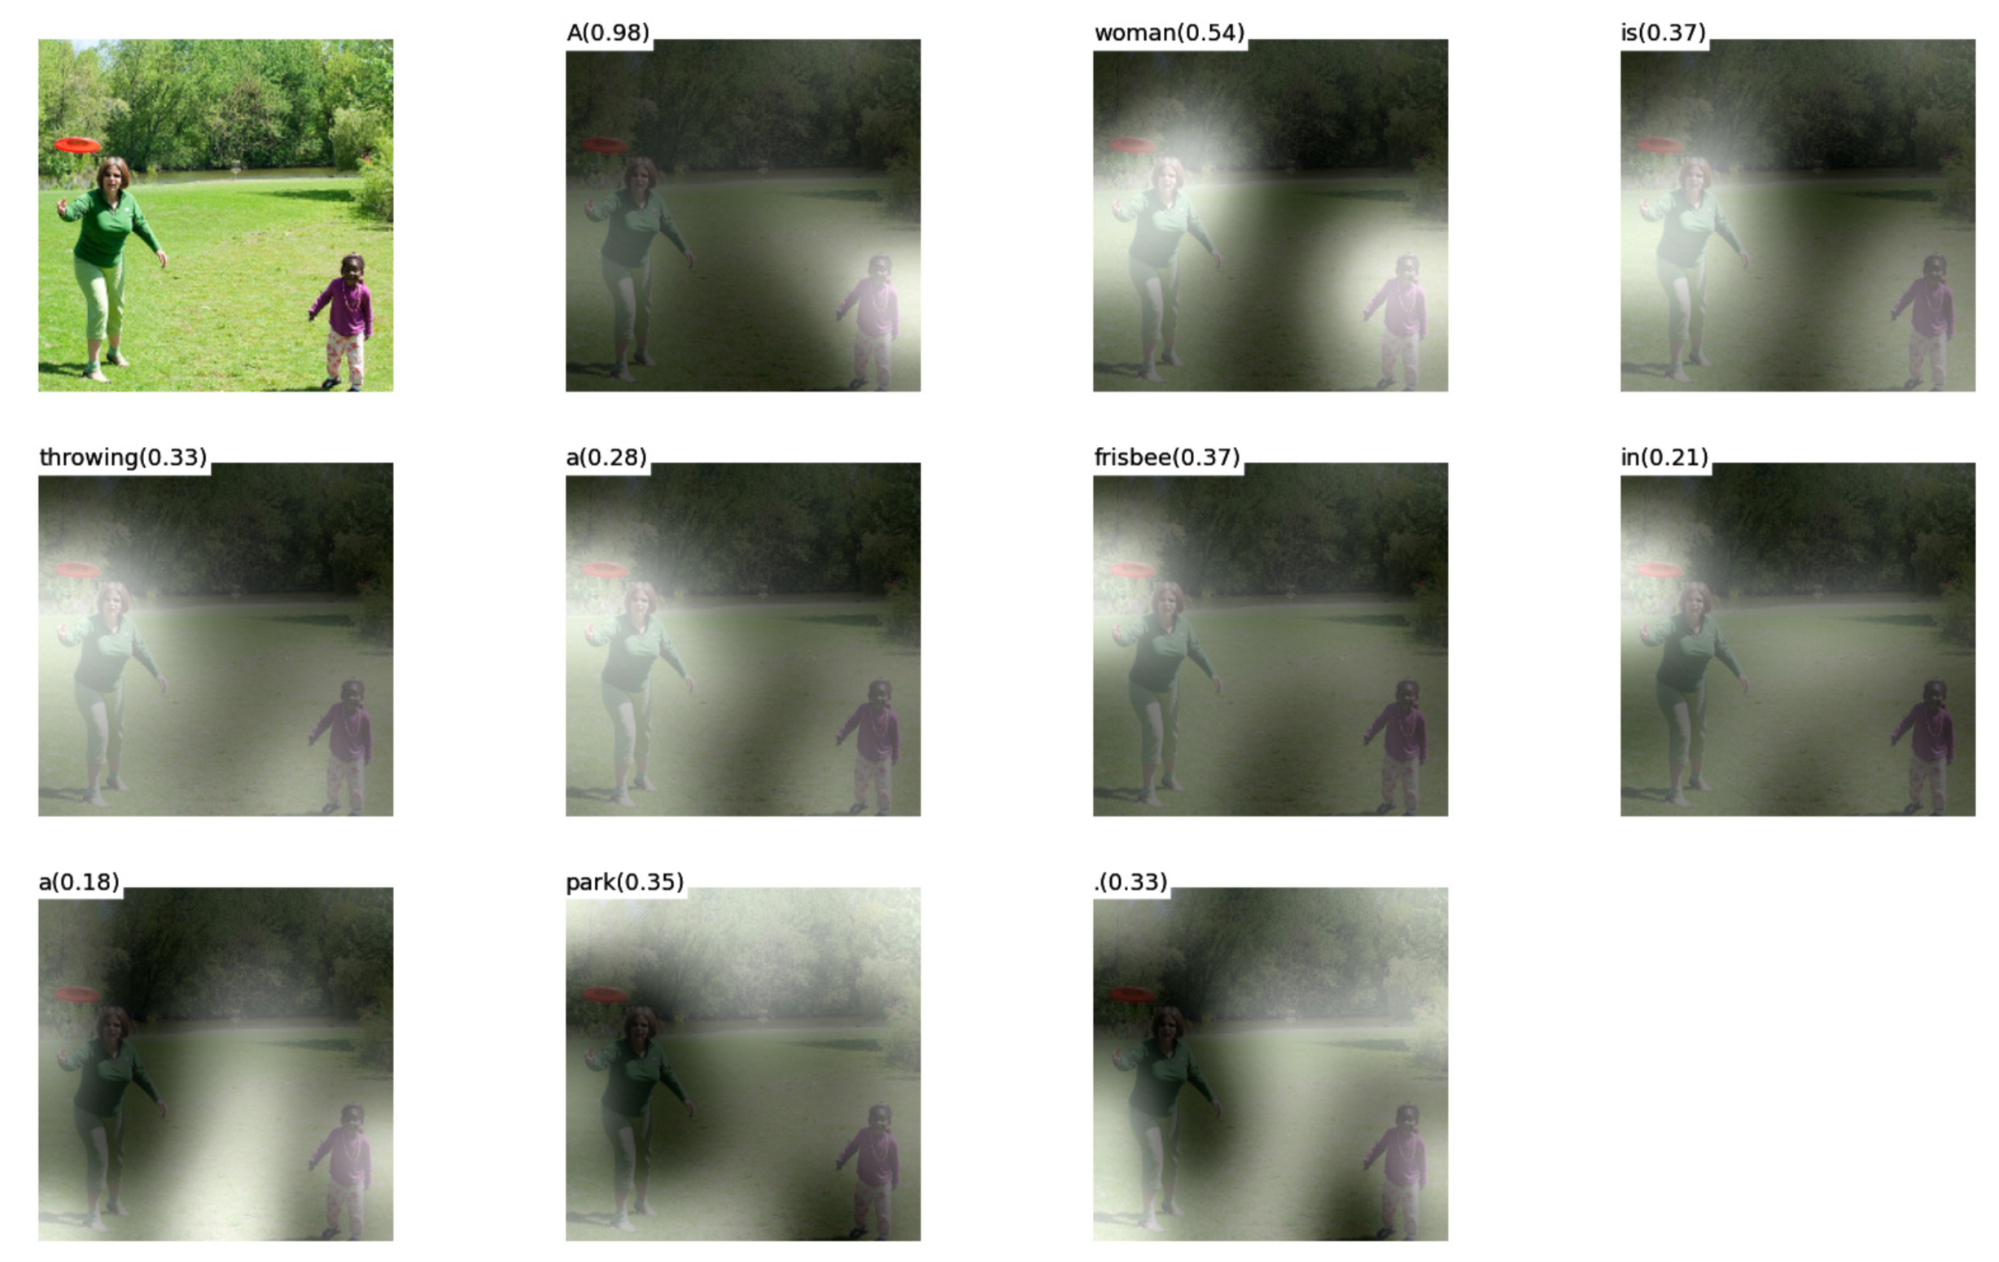
“A woman is throwing a frisbee in a park.” (Image source: Fig. 6(b) in Xu et al. 2015)

**Soft** vs. **hard** attention is whether the attention mechanism has access to the whole image or just a patch at a time.

In **soft** attention, the alignment weights are learned and placed "softly" over all patches in the source image.  The the model is smooth and differentiable, but expensive when the source input is large.

In **hard** attention, only one patch of the image is attended to at a time.  This takes less calculation at inference time, but the model is non-differentiable and requires more complicated techniques such as variance reduction or reinforcement learning to train.

## Key, Value, Query

["Attention Is All You Need"](http://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf) (Vaswani, et al., 2017) presented a lot of improvements to soft attention to make it possible to do `seq2seq` modeling *without* recurrent network units. The proposed “transformer” model is entirely built on the self-attention mechanisms without using sequence-aligned recurrent architecture.

The major component in the transformer is *multi-headed self-attention*. This is a self-attention mechanism in that both source and target are the same sequence, but "multi-headed" in that it allows attention to be paid to multiple elements of the source/target sequence for every single element of the other.

The transformer views the encoded representation of the input as a set of key-value pairs, ($K$,$V$), both of dimension $n$ (input sequence length).  Since this is self-attention, and the input becomes both "source" and "target", "source" and "target" become "key" and "value".

For example, in neural machine translation, both the key and value are the encode hidden states at each timestep.  Therefore key and value at the last time step will be the sentence embedding.

In the decoder, the output at the previous timestep is compressed into a *query* ($Q$ of dimension $m$) and the next output is produced by mapping this query and the set of keys and values using *scaled dot-product attention*.

$$\text{Attention}(Q,K,V) = \text{softmax}(\frac{QK^T}{\sqrt{n}})V$$

Compare to standard scaled dot product attention: $$\text{Attention}(s,h) = \text{softmax}(\frac{s_t^Th_i}{\sqrt n})$$

The current input (encoder hidden state $h_i$) becomes the "key" $K$, while the previous output (decoder hidden state $s_t$) becomes the "query" $Q$.  This product is scaled and softmaxed then multiplied by the target $V$.  In this way we should be able to capture how much information is relevant to both this input and the output we have so far, and then take that and multiply it by the target.  Because this is self-attention, the target is the same as the source.

The below example shows how to calculate the scaled dot product attention for a sample sentence: `"The animal didn't cross the street because it was too tired."`

In [ ]:
w2i = {"<SOS>" : 0,
       "<EOS>" : 1,
       "the" : 2,
       "animal" : 3,
       "did" : 4,
       "n't" : 5,
       "cross" : 6,
       "street" : 7,
       "because" : 8,
       "it" : 9,
       "was" : 10,
       "too" : 11,
       "tired" : 12,
       "." : 13,
       "wide" : 14
      }

sentence = "<SOS> the animal did n't cross the street because it was too tired . <EOS>"
indices = np.array([w2i[word] for word in sentence.split()])

x = np.zeros((indices.size, indices.max()+1))
x[np.arange(indices.size),indices] = 1
y = x
x

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Because the encoder and decoder are neural nets, they will be initialized as weight matrices.  We're not doing any training here so the weights aren't optimized.  You can think of this as calculating the scaled dot product self-attention in the first epoch of training, before any weight update is performed.

In [ ]:
dummy_encoder_weights = np.random.uniform(-1,1,size=(14,128))
dummy_decoder_weights = np.random.uniform(-1,1,size=(128,14))

In [ ]:
keys = (x@dummy_encoder_weights).T
keys.shape

(128, 15)

In [ ]:
attentions = []

for t in range(0,len(sentence.split())):
    query = x[t]@dummy_decoder_weights.T
    attention = softmax(query.T @ keys)
    attentions.append(attention * keys)

In [ ]:
attentions = np.array(attentions)
attentions = np.sum(attentions,axis=1)

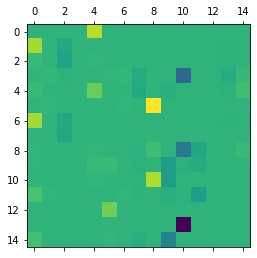

In [ ]:
plt.matshow(attentions)

Attention at this point is fairly random.  After training, the values should be optimized and we should see something much more like this:

<img src="https://github.com/sarathsreedharan/CSU_CS_445/blob/main/Spring25/Notebooks/images/animal-street.png?raw=1">

In the first sentence, the attention weights should be optimized to correlate "it" and "animal" more than "it" and street (because animals can get tired, and here and elsewhere in the data, we should find collocations of "animal" or animal words and "tired").

In the second, the opposite is true (because streets can be wide).

**Speculate**: What might happen if the sentence were `"The animal didn't cross the street because it was too busy."`?

## Multi-Headed Self-Attention

<img src="https://github.com/sarathsreedharan/CSU_CS_445/blob/main/Spring25/Notebooks/images/multi-head-attention.png?raw=1" width=400>

Rather than only computing the attention once, the multi-head mechanism runs through the scaled dot-product attention multiple times in parallel. The independent attention outputs are simply concatenated and linearly transformed into the expected dimensions.

From Vaswani et al., 2017: "_multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this._"

Anyway, multi-headed attention is calculated as

$$\text{MultiHead}(Q,K,V) = [\text{head}_1;...;\text{head}_h]W^O$$

where $\text{head}_i = \text{Attention}(QW_i^Q,KW_i^K,VW_i^V)$, and $W_i^Q$, $W_i^K$, $W_i^V$, and $W^O$ are learnable weight matrices associated with the query, key, and value at each timestep, and the overall output, respectively.

## Transfomer Encoder

<img src="https://github.com/sarathsreedharan/CSU_CS_445/blob/main/Spring25/Notebooks/images/transformer-encoder.png?raw=1" width=400>

The transformer encoder uses a stack of 6 identical encoders. Why 6?

🤷‍♂️
==

It seemed to work best (Vaswani et al., 2017).

* Each layer has a multi-headed self-attention layer and a simple position-wise fully connected feed-forward network.
* Each sub-layer adopts a residual connection and a layer normalization.
* All the sub-layers output $\mathbb{R}^{512}$ in the original transformer, but dimensionality can vary (e.g., BERT uses $\mathbb{R}^{768}$).

## Transformer Decoder

<img src="https://github.com/sarathsreedharan/CSU_CS_445/blob/main/Spring25/Notebooks/images/transformer-decoder.png?raw=1" width=400>

The decoder is also a stack of 6 identical layers

* Each layer has two sub-layers of multi-head attention mechanisms and one sub-layer of fully-connected feed-forward network.
* Similar to the encoder, each sub-layer adopts a residual connection and a layer normalization.
* The first multi-head attention sub-layer is modified to prevent positions from attending to subsequent positions, as we don’t want to look into the future of the target sequence when predicting the current position (or do we? more on that later).

## Full Architecture

<img src="https://github.com/sarathsreedharan/CSU_CS_445/blob/main/Spring25/Notebooks/images/transformer.png?raw=1">

* Both the source and target sequences first go through embedding layers to produce representations in $\mathbb{R}^{512}$.
* A softmax and linear layer are added to the final decoder output.
* To preserve the position information, a sinusoidal-wave-based positional encoding is applied and summed with the embedding output.

The positional encoding represents the position of a word in the input, and therefore the distance between words in the input.  These encodings could be learned, but the AIAYN authors found that learning the encodings added more parameters to the model without being more effective (Transformers are heavy enough!)

How does a sinusoidal wave represent integer positions?  Aren't sine waves periodic?

In [ ]:
for i in range(16):
    print(np.binary_repr(i,4))

0000
0001
0010
0011
0100
0101
0110
0111
1000
1001
1010
1011
1100
1101
1110
1111


So are binary numbers, but storing these is a waste of space, so we can use a comparable floating point representation, a sinusoidal wave.  Therefore a combination of sinusoidal waves with different periods can represent an arbitrary position.

Pick some encoding dimension $d$ that is divisible by 2.  The positional encoding $\overrightarrow p_t^{(i)}$ will be a function $f :  \mathbb{N}\rightarrow \mathbb{R}^d$ consisting of pairs of sines and cosines for each frequency $1..\frac{d}{2}$.

In [ ]:
def positional_encoding(t,d=256,l=12):
    assert t < l
    d = d
    l = l

    p_t = np.array([[np.sin((1/(10000**(2*k/d)))*t),np.cos((1/(10000**(2*k/d)))*t)] for k in range(int(d/2))])

    return p_t

In [ ]:
positional_encoding(11)

array([[-0.99999021,  0.0044257 ],
       [-0.72533058, -0.68840072],
       [-0.10065883, -0.994921  ],
       [ 0.53162153, -0.84698203],
       [ 0.92305248, -0.38467404],
       [ 0.98422718,  0.17690917],
       [ 0.75785081,  0.65242789],
       [ 0.35608506,  0.93445354],
       [-0.09727666,  0.99525738],
       [-0.50285193,  0.86437257],
       [-0.79954816,  0.60060198],
       [-0.9631406 ,  0.26899847],
       [-0.99728336, -0.07366067],
       [-0.92269604, -0.38552824],
       [-0.76775034, -0.6407491 ],
       [-0.56169782, -0.82734247],
       [-0.33057501, -0.94377972],
       [-0.09526256, -0.99545218],
       [ 0.12897081, -0.99164839],
       [ 0.33204073, -0.94326505],
       [ 0.50818974, -0.86124514],
       [ 0.65500193, -0.7556272 ],
       [ 0.77246598, -0.63505615],
       [ 0.86217349, -0.50661313],
       [ 0.92668158, -0.37584738],
       [ 0.96903539, -0.24692188],
       [ 0.99242995, -0.12281201],
       [ 0.99998478, -0.00551747],
       [ 0.99460489,

So those are the key attention mechanisms and other components used in transformers.  As we now know, attention mechanisms are alignment weights that help an encoder and decoder match parts of sequences to each other.

What does this mean?

## Contextualized Embeddings

We are now familiar with `word2vec` as a way to turn words into fixed-length vectors by training to predict them from their context.  Let's load up some word vectors and examine their similarity.

In [ ]:
def cos_sim(a,b):
    return np.inner(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [ ]:
start_time = time.time()
import gensim
from gensim.models.keyedvectors import KeyedVectors
model = KeyedVectors.load_word2vec_format("data/GoogleNews-vectors-negative300.bin", binary=True)
print("Data loaded in %.4f seconds" % (time.time()-start_time,))

Data loaded in 12.6132 seconds


Let's look at a word we know has multiple meanings: "bank".

In [ ]:
model["bank"]

array([ 2.19726562e-02,  1.34765625e-01, -5.78613281e-02,  5.56640625e-02,
        9.91210938e-02, -1.40625000e-01, -3.03649902e-03,  1.87988281e-02,
        2.53906250e-01, -4.88281250e-02, -1.63574219e-02, -1.33666992e-02,
        6.25000000e-02,  6.07910156e-02, -9.22851562e-02,  3.12500000e-01,
        1.38282776e-04, -1.34765625e-01, -4.32128906e-02,  1.16699219e-01,
        2.22656250e-01, -9.81445312e-02,  4.51660156e-02, -2.23388672e-02,
        5.17578125e-02, -2.41210938e-01, -1.11328125e-01,  9.71679688e-02,
        2.28515625e-01, -1.08642578e-02, -4.02832031e-02, -1.83105469e-02,
        3.10546875e-01,  3.88183594e-02, -2.85156250e-01, -2.06054688e-01,
        3.69140625e-01, -5.24902344e-02,  1.30859375e-01,  1.51367188e-01,
        1.59179688e-01, -2.36328125e-01,  7.47070312e-02, -5.54199219e-02,
       -8.64257812e-02, -2.28515625e-01,  2.44140625e-03,  8.11767578e-03,
       -1.62109375e-01,  1.46484375e-01,  1.40625000e-01, -3.82995605e-03,
        1.09375000e-01,  

A bank is the shore of a river.

In [ ]:
model["riverbank"]

array([ 1.06445312e-01,  6.10351562e-02, -5.71289062e-02,  7.42187500e-02,
        7.61718750e-02, -2.36328125e-01, -1.14746094e-01, -7.51953125e-02,
        7.51953125e-02,  7.03125000e-02,  4.43359375e-01, -1.35742188e-01,
        1.23046875e-01,  1.76757812e-01, -6.10351562e-02, -2.69531250e-01,
       -1.97265625e-01, -1.98242188e-01,  8.44726562e-02,  5.10253906e-02,
       -1.06445312e-01,  8.25195312e-02, -2.04101562e-01,  3.97949219e-02,
        3.88671875e-01, -5.11718750e-01, -3.18359375e-01,  7.37304688e-02,
        1.43554688e-01, -2.31445312e-01, -2.65625000e-01,  1.66992188e-01,
       -8.25195312e-02, -1.53320312e-01, -8.49609375e-02, -2.53906250e-01,
        2.09960938e-01,  7.86132812e-02, -5.98144531e-02, -2.08984375e-01,
       -4.92187500e-01,  2.41699219e-02,  7.76367188e-02, -1.64062500e-01,
       -1.65039062e-01, -2.92968750e-01,  6.16455078e-03,  1.06933594e-01,
        2.01171875e-01,  7.08007812e-02,  3.47656250e-01, -1.02539062e-01,
        2.50000000e-01, -

In [ ]:
cos_sim(model["bank"],model["riverbank"])

0.12643033

??? That's not very similar.

In [ ]:
cos_sim(model["bank"],model["river"])

0.2152313

In [ ]:
cos_sim(model["bank"],model["money"])

0.26132068

In [ ]:
model.most_similar("bank")

[('banks', 0.7440759539604187),
 ('banking', 0.6901614665985107),
 ('Bank', 0.6698698401451111),
 ('lender', 0.634228527545929),
 ('banker', 0.6092953681945801),
 ('depositors', 0.6031531691551208),
 ('mortgage_lender', 0.5797975659370422),
 ('depositor', 0.5716428160667419),
 ('BofA', 0.5714625120162964),
 ('Citibank', 0.5589520931243896)]

In [ ]:
cos_sim(model["bank"],model["Wells_Fargo"])

0.45348078

In [ ]:
cos_sim(model["bank"],model["finance"])

0.33500585

So clearly this bank is the other kind of bank.

**Note**: A *polysemous* word is commonly used for a word with multiple meanings.  Another word for this is a *homonym*.

There's a difference.

*Polyseme*: Two words with the same spelling, same origin, and different meanings.

*Homonym*: Two words with the same spelling, *different* origins, and different meanings.

Which one is "bank"?

The "riverbank" sense comes from Germanic, originally meaning "bench" or "flat area."  The "money" sense was borrowed from Italian via French, so the origins are different, making it a homonym.

*Except*: the Italian word *banca* was actually borrowed from German, in the sense of "moneychanging table" or... "bench" or "flat thing."  Meaning "bank" is actually a true polyseme.

Transformers and `word2vec` don't know any of this, stupid things...

We can try a couple of other examples of words with multiple meanings.

In [ ]:
model.most_similar("arms")

[('weapons', 0.5423978567123413),
 ('stimulates_innate_immunity', 0.5276414752006531),
 ('Copacabana_frantically', 0.5087413191795349),
 ('armaments', 0.4976296126842499),
 ('doctors_revived_Coltyn', 0.48752522468566895),
 ('arm', 0.48622867465019226),
 ('Copacabana_frantically_waving_flags', 0.47894036769866943),
 ('Arms', 0.47419044375419617),
 ('cradling_squirming_infant', 0.4572297930717468),
 ('bowled_shouldering', 0.4543934464454651)]

In [ ]:
model.most_similar("bark")

[('barks', 0.6022706031799316),
 ('Pacific_yew_tree', 0.5659282803535461),
 ('barking', 0.5538278222084045),
 ('cork_oak_tree', 0.5402647256851196),
 ('beetles_burrow', 0.5370648503303528),
 ('barky', 0.5280892848968506),
 ('cambium', 0.5276376605033875),
 ('sapwood', 0.5159558057785034),
 ('frass', 0.5140876173973083),
 ('barked', 0.5108721852302551)]

These word vectors were trained from Google News.  Does this distribution make sense?

Now we're going to get some contextually-dependent vectors using BERT.

We will go into details about BERT, its differences from the original transformer architecture, and other transformer variants, in the next lecture, but for now what you need to know is that to compute embeddings, BERT **requires** a sentence as input.  Context is computed using the sentence.

<img src="https://github.com/sarathsreedharan/CSU_CS_445/blob/main/Spring25/Notebooks/images/firth.png?raw=1" width=200>
<img src="https://github.com/sarathsreedharan/CSU_CS_445/blob/main/Spring25/Notebooks/images/wittgenstein.jpg?raw=1" width=200>

In [ ]:
# empty cell, run necessary BERT installs here with !pip install ####

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from ipywidgets import FloatProgress

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

First we need to tokenize all inputs.  Let's see how BERT tokenizes a sentence.

In [ ]:
text = "Here is the sentence I want embeddings for."
marked_text = "[CLS] " + text + " [SEP]" # more about the [CLS] and [SEP] tokens next time

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
print (tokenized_text)

['[CLS]', 'here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.', '[SEP]']


This is subword tokenization.  Why does BERT do it this way?  The BERT tokenizer was created with a WordPiece model. This model greedily creates a fixed-size vocabulary of individual characters, subwords, and words that best fits our language data. Since the vocabulary limit size of our BERT tokenizer model is 30,000, the WordPiece model generated a vocabulary that contains all English characters plus the ~30,000 most common words and subwords found in the English language corpus the model is trained on. So "embeddings" isn't in that top 30K, but "em" (e.g., "go get 'em") is, as is "bed", and I guess "ding," and the single character "s".

Remember stupid machine learning tricks?  IMO this is an objectively dumb way to break up the word "embeddings," but I guess it works, and that's very frustrating to me.

Here are some examples of the tokens contained in our vocabulary. Tokens beginning with two hashes are subwords or individual characters.

In [ ]:
list(tokenizer.vocab.keys())[5000:5020]

['knight',
 'lap',
 'survey',
 'ma',
 '##ow',
 'noise',
 'billy',
 '##ium',
 'shooting',
 'guide',
 'bedroom',
 'priest',
 'resistance',
 'motor',
 'homes',
 'sounded',
 'giant',
 '##mer',
 '150',
 'scenes']

After breaking the text into tokens, we then have to convert the words in the sentence to vocabulary indeces.

From here on, we’ll use the example sentence below, which contains two instances of the word “bank” with different meanings.

In [ ]:
# Define a new example sentence with multiple meanings of the word "bank"
text = "After stealing money from the bank vault, the bank robber was seen " \
       "fishing on the Mississippi river bank."

# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
after         2,044
stealing     11,065
money         2,769
from          2,013
the           1,996
bank          2,924
vault        11,632
,             1,010
the           1,996
bank          2,924
robber       27,307
was           2,001
seen          2,464
fishing       5,645
on            2,006
the           1,996
mississippi   5,900
river         2,314
bank          2,924
.             1,012
[SEP]           102


BERT is trained on and expects sentence pairs, using 1s and 0s to distinguish between the two sentences. That is, for each token in “tokenized_text,” we must specify which sentence it belongs to: sentence 0 (a series of 0s) or sentence 1 (a series of 1s). Since this example uses only a single sentence, every index will be marked with 1s.

In [ ]:
# Mark each of the 22 tokens as belonging to sentence "1".
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


We will now convert everything to tensors and load the pre-trained model.

In [ ]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [ ]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers.
with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)

    # Evaluating the model will return a different number of objects based on
    # how it's  configured in the `from_pretrained` call earlier. In this case,
    # becase we set `output_hidden_states = True`, the third item will be the
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]

In [ ]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 22
Number of hidden units: 768


In [ ]:
# `hidden_states` is a Python list.
print('      Type of hidden_states: ', type(hidden_states))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', hidden_states[0].size())

      Type of hidden_states:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 22, 768])


In [ ]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 22, 768])

In [ ]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 22, 768])

In [ ]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([22, 13, 768])

Now we have 22 tokens, representations for each in the 13 layers, each of which consist of 768 dimensions.  Now we have a way to extract a representation in $\mathbb{R}^{768}$ for each token, from each layer.

In [ ]:
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)

    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))


Shape is: 22 x 3072


In [ ]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)

    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))


Shape is: 22 x 768


In [ ]:
# `hidden_states` has shape [13 x 1 x 22 x 768]

# `token_vecs` is a tensor with shape [22 x 768]
token_vecs = hidden_states[-2][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)

In [ ]:
print ("Our final sentence embedding vector of shape:", sentence_embedding.size())

Our final sentence embedding vector of shape: torch.Size([768])


In [ ]:
for i, token_str in enumerate(tokenized_text):
    print (i, token_str)

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


In [ ]:
print('First 5 vector values for each instance of "bank".')
print('')
print("bank vault   ", str(token_vecs_sum[6][:5]))
print("bank robber  ", str(token_vecs_sum[10][:5]))
print("river bank   ", str(token_vecs_sum[19][:5]))

First 5 vector values for each instance of "bank".

bank vault    tensor([ 3.3596, -2.9805, -1.5421,  0.7065,  2.0031])
bank robber   tensor([ 2.7359, -2.5577, -1.3094,  0.6797,  1.6633])
river bank    tensor([ 1.5266, -0.8895, -0.5152, -0.9298,  2.8334])


Those look different!

In [ ]:
# Calculate the cosine similarity between the word bank
# in "bank robber" vs "river bank" (different meanings).
diff_bank = cos_sim(token_vecs_sum[6], token_vecs_sum[19])

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "bank vault" (same meaning).
same_bank = cos_sim(token_vecs_sum[10], token_vecs_sum[6])

print('Vector similarity for *similar* meanings:\t%.2f' % same_bank)
print('Vector similarity for *different* meanings:\t%.2f' % diff_bank)

Vector similarity for *similar* meanings:	0.94
Vector similarity for *different* meanings:	0.70
